##Laboratory work 4

This lab involved numerically solving Poisson's equation in a rectangle using existing direct solvers for systems of linear equations. We need to solve the problem from point (a), construct the exact solution, the numerical one and the error. Also we need to solve the problem from point (b), the setting of boundary conditions in both points is the same.

a) Find a solution to the Poisson equation in a periodically closed domain:
\begin{equation}
  \begin{cases}
    \Delta u = -32\cos(4x) - 25\sin(4x + 3y) \\
    u(x+\pi, y) = u(x, y) \\
    u(x, y+2\pi) = u(x, y) \\
    0 < x < \pi, 0 < y < 2\pi
  \end{cases}
\end{equation}

Exact solution:
\begin{equation}
  u_0(x, y) = 2\cos(4x) + \sin(4x+3y)
\end{equation}

b) At the nodes of a square lattice, positively and negatively charged ions with charges q1 and q2 are arranged in a checkerboard pattern. We assume that the grating creates an electrostatic field that satisfies the screened Poisson equation. Draw field strength lines.

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import linalg
import time
import matplotlib.pyplot as plt

In [2]:
# grid creating
h0 = 0.01
l_x = np.pi
l_y = np.pi * 2
nx = int(np.round(l_x / h0))
ny = int(np.round(l_y / h0))

hx = l_x / nx
hy = l_y / ny

x = np.linspace(0.5 * hx, l_x - 0.5 * hx, nx)
y = np.linspace(0.5 * hy, l_y - 0.5 * hy, ny)
X, Y = np.meshgrid(x, y, indexing = 'ij')

In [22]:
# cells indexing
k = np.arange(nx * ny, dtype=int).reshape((nx, ny))

# pair of indices
I, J = np.meshgrid(np.arange(nx), np.arange(ny))
I, J = I.flatten(), J.flatten()

iC = k[I, J].flatten()

iB = k[I, (J - 1) % ny].flatten()
iT = k[I, (J + 1) % ny].flatten()

iL = k[(I - 1) % nx, J].flatten()
iR = k[(I + 1) % nx, J].flatten()

# matrix filling
R1, C1, V1 = iC, iC, np.full(iC.size, +2.0 / hy**2 + 2.0 / hx**2)
R2, C2, V2 = iC, iB, np.full(iC.size, -1.0 / hy**2)
R3, C3, V3 = iC, iT, np.full(iC.size, -1.0 / hy**2)
R4, C4, V4 = iC, iL, np.full(iC.size, -1.0 / hx**2)
R5, C5, V5 = iC, iR, np.full(iC.size, -1.0 / hx**2)

row = np.concatenate((R1, R2, R3, R4, R5))
col = np.concatenate((C1, C2, C3, C4, C5))
val = np.concatenate((V1, V2, V3, V4, V5))

L = sp.csr_matrix((val, (row, col)), shape=(nx * ny, nx * ny))

In [23]:
# right side
def RHS(X, Y):
  res = 32 * np.cos(4*X) + 25 * np.sin(4*X + 3*Y)
  return res - res.mean()

def exact_solution(X, Y):
    res = 2 * np.cos(4 * X) + np.sin(4 * X + 3 * Y)
    return res - res.mean()

In [24]:
f = RHS(X, Y).flatten()
u_analit = exact_solution(X, Y)

start = time.time()
u_sp = linalg.spsolve(L, f)
u_sp = u_sp.reshape((nx, ny))
time_sp = time.time() - start
u_sp -= u_sp.mean()
error_sp = np.max(np.abs(u_sp - u_analit))

start = time.time()
u_bic, b = linalg.bicgstab(L, f)
u_bic = u_bic.reshape((nx, ny))
time_bic = time.time() - start
u_bic -= u_bic.mean()
error_bic = np.max(np.abs(u_bic - u_analit))

print("spsolve time: ", time_sp, ", error = ", error_sp)
print("bicgstab:     ", time_bic, ", error = ", error_bic)

spsolve time:  0.00931859016418457 , error =  0.03910621013126736
bicgstab:      0.0006439685821533203 , error =  0.039106210131277575


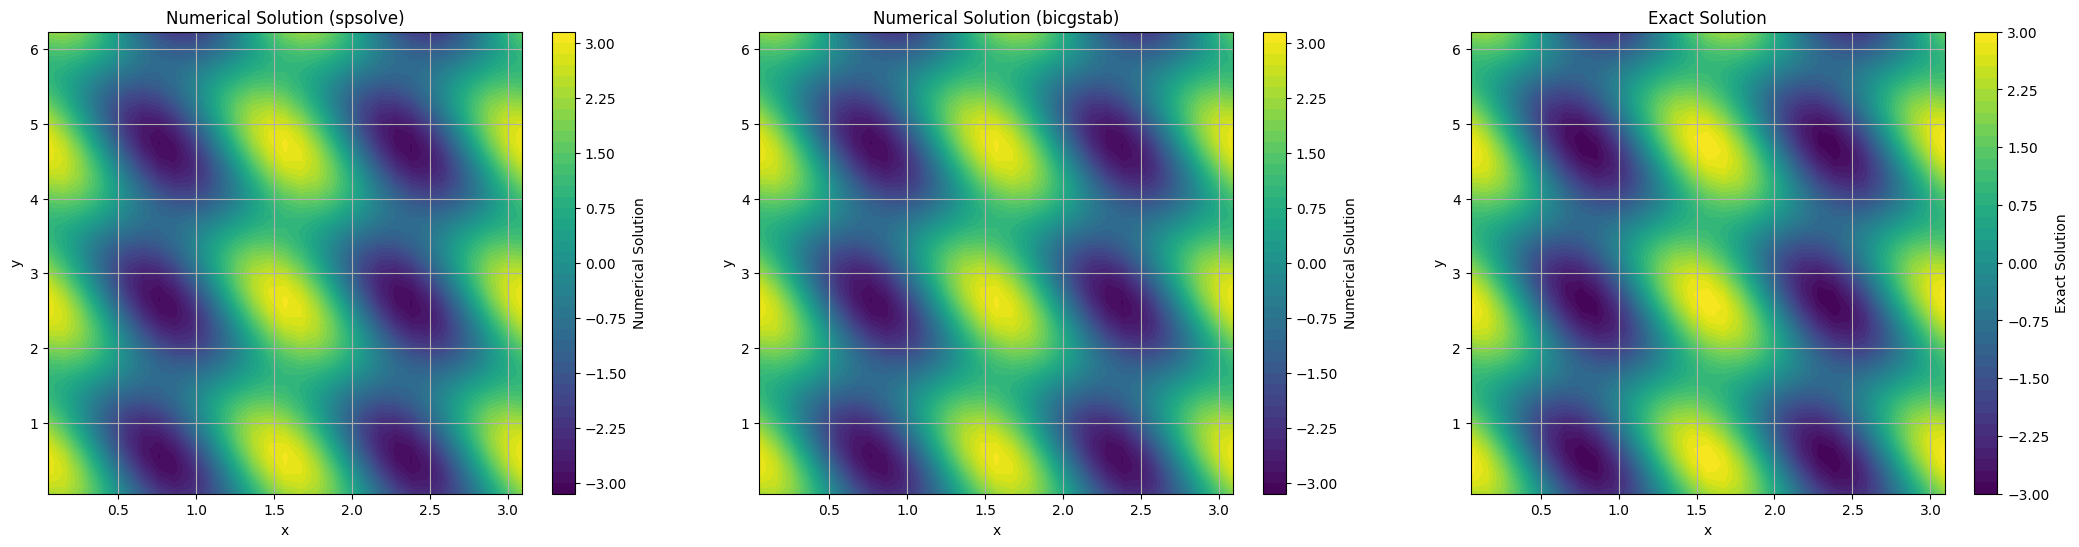

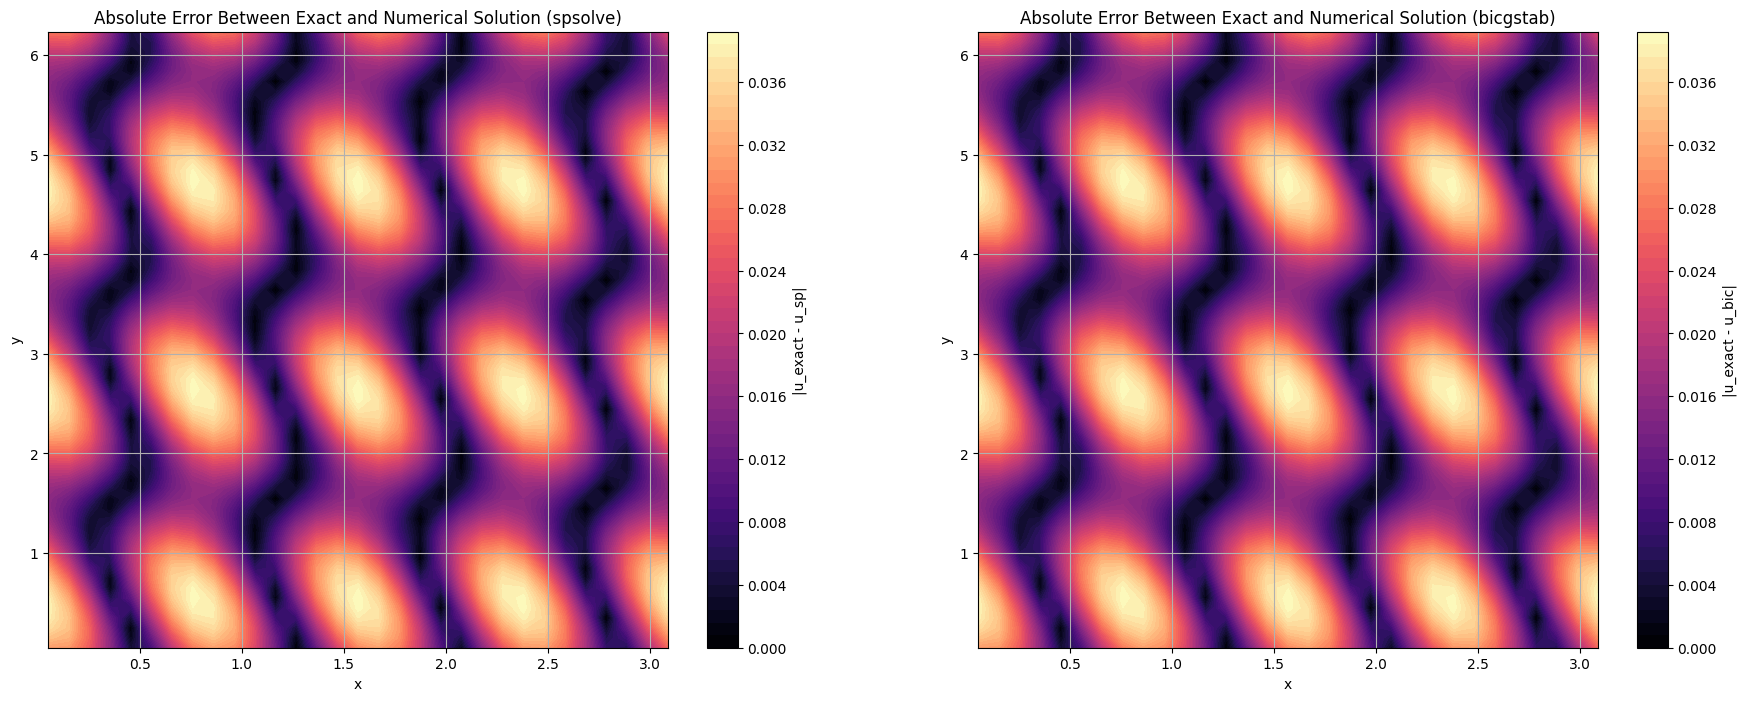

In [34]:
plt.figure(figsize=(26, 6))

plt.subplot(1, 3, 1)
plt.contourf(X, Y, u_sp, levels=50, cmap='viridis')
plt.colorbar(label='Numerical Solution')
plt.title('Numerical Solution (spsolve)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.contourf(X, Y, u_bic, levels=50, cmap='viridis')
plt.colorbar(label='Numerical Solution')
plt.title('Numerical Solution (bicgstab)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.contourf(X, Y, u_analit, levels=50, cmap='viridis')
plt.colorbar(label='Exact Solution')
plt.title('Exact Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.show()

plt.figure(figsize=(22, 8))
plt.subplot(1, 2, 1)
plt.contourf(X, Y, np.abs(u_analit - u_sp), levels=50, cmap='magma')
plt.colorbar(label='|u_exact - u_sp|')
plt.title('Absolute Error Between Exact and Numerical Solution (spsolve)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.contourf(X, Y, np.abs(u_analit - u_bic), levels=50, cmap='magma')
plt.colorbar(label='|u_exact - u_bic|')
plt.title('Absolute Error Between Exact and Numerical Solution (bicgstab)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

In [26]:
def RHS_b(X, Y, q1=1, q2=-1, nx=5, ny=10):

    Lx = X.max() - X.min()
    Ly = Y.max() - Y.min()

    period_x = Lx / nx
    period_y = Ly / ny

    nodes = ((np.floor(X / period_x) + np.floor(Y / period_y)) % 2)
    nodes = np.where(nodes == 0, q1, q2)

    res = nodes
    return res - res.mean()

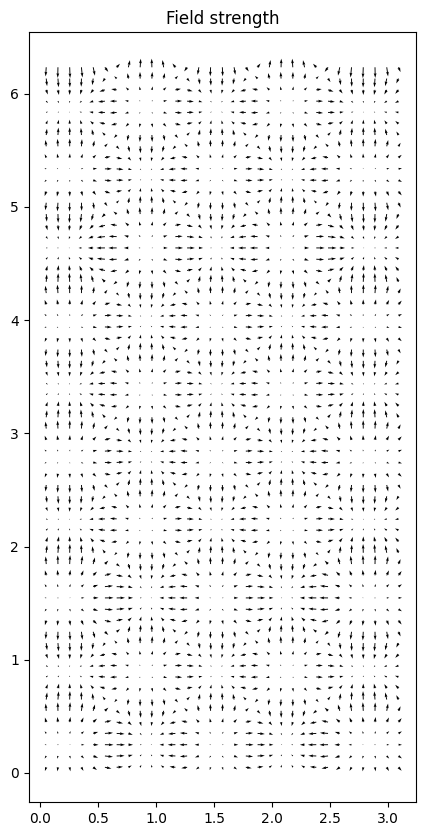

In [58]:
h0 = 0.1
l_x = np.pi
l_y = np.pi * 2
nx = int(np.round(l_x / h0))
ny = int(np.round(l_y / h0))

hx = l_x / nx
hy = l_y / ny

x = np.linspace(0.5 * hx, l_x - 0.5 * hx, nx)
y = np.linspace(0.5 * hy, l_y - 0.5 * hy, ny)
X, Y = np.meshgrid(x, y, indexing = 'ij')

k_s = 1.0 #screening factor

k = np.arange(nx * ny, dtype=int).reshape((nx, ny))

I, J = np.meshgrid(np.arange(nx), np.arange(ny))
I, J = I.flatten(), J.flatten()

iC = k[I, J].flatten()

iB = k[I, (J - 1) % ny].flatten()
iT = k[I, (J + 1) % ny].flatten()

iL = k[(I - 1) % nx, J].flatten()
iR = k[(I + 1) % nx, J].flatten()

R1, C1, V1 = iC, iC, np.full(iC.size, +2.0 / hy**2 + 2.0 / hx**2 + k_s**2)
R2, C2, V2 = iC, iB, np.full(iC.size, -1.0 / hy**2)
R3, C3, V3 = iC, iT, np.full(iC.size, -1.0 / hy**2)
R4, C4, V4 = iC, iL, np.full(iC.size, -1.0 / hx**2)
R5, C5, V5 = iC, iR, np.full(iC.size, -1.0 / hx**2)

row = np.concatenate((R1, R2, R3, R4, R5))
col = np.concatenate((C1, C2, C3, C4, C5))
val = np.concatenate((V1, V2, V3, V4, V5))

L_screened = sp.csr_matrix((val, (row, col)), shape=(nx * ny, nx * ny))

q1, q2 = 2.0, -1.0

f_charges = RHS_b(X, Y, q1, q2, 5, 10).flatten()

phi = linalg.spsolve(L_screened, f_charges)
phi = phi.reshape((nx, ny))

Ex, Ey = np.gradient(-phi, hx, hy)

plt.figure(figsize=(5, 10))
plt.quiver(X, Y, Ex, Ey)
plt.title("Field strength")
plt.show()